In [58]:
import umap
import torch

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from pedalboard.pedalboard import load_plugin
from sklearn.preprocessing import LabelEncoder

from src.dataset.audio_dataset import AudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.utils import audio_to_mel_spectrogram

from src.models.vqvae.mel_spec_vqvae import MelSpecVQVAE

sns.set(style='white', context='poster')

In [59]:
DAFX_TO_USE = [
    'mda MultiBand',
    # 'clean',
    'mda Delay',
    'mda Overdrive',
    # 'mda Ambience',
    'mda RingMod',
    # 'mda Leslie',
    # 'mda Combo',
    'mda Thru-Zero Flanger',
    # 'mda Loudness',
    # 'mda Limiter',
    # 'mda Dynamics',
]

In [60]:
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_MelSpecVQVAE/2ioetrxf/checkpoints/epoch=27-step=8764.ckpt"
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES = 2_500
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 4

In [61]:
model = MelSpecVQVAE.load_from_checkpoint(CHECKPOINT).to(DEVICE)
model.eval()

MelSpecVQVAE(
  (_encoder): Encoder(
    (_conv_1): Conv2d(1, 4, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
    (_conv_2): Conv2d(4, 8, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1))
    (_conv_3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
        (1): Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )
    )
  )
  (

In [62]:
proj = umap.UMAP().fit_transform(model._vq_vae._embedding.weight.data.cpu())

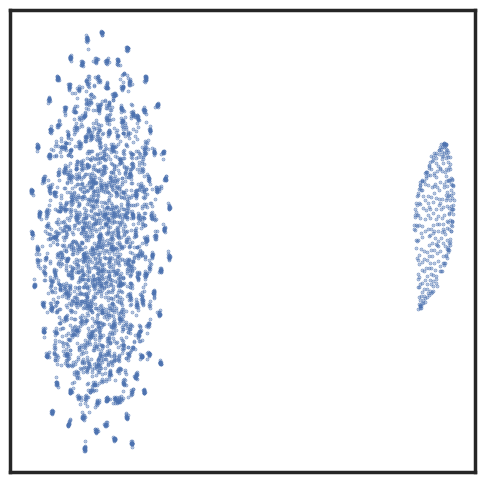

In [63]:
fig, ax = plt.subplots(1, figsize=(6,6))

ax.scatter(proj[:,0], proj[:,1], alpha=0.7, s=0.4)

ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [64]:
def dafx_from_name(dafx_name):
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [65]:
def get_dataset(dafx):
    dataset = AudioDataset(
        dafx=dafx,
        audio_dir=AUDIO_DIR,
        subset="train",
        input_dirs=DATASETS,
        num_examples_per_epoch=NUM_EXAMPLES,
        augmentations={},
        length=130_560,
        effect_audio=True,
        dummy_setting=True
    )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=BATCH_SIZE,
        timeout=6000,
    )

In [66]:
dafx = dafx_from_name(DAFX_TO_USE[-1])
dataset = get_dataset(dafx)

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 40132.52it/s]


Loaded 88 files for train = 66.89 hours.


In [67]:
from tqdm import tqdm

embeddings = []

for fx in DAFX_TO_USE:
    dafx = dafx_from_name(fx)
    dataset = get_dataset(dafx)

    for x in tqdm(dataset):
        X = audio_to_mel_spectrogram(signal=x,
                                     sample_rate=model.hparams.sample_rate,
                                     n_mels=model.hparams.n_mels,
                                     n_fft=model.hparams.n_fft,
                                     win_length=model.hparams.win_length,
                                     f_max=model.hparams.f_max,
                                     f_min=model.hparams.f_min).to(DEVICE)

        z = model._encoder(X)
        z = model._pre_vq_conv(z)
        loss, quantized, perplexity, enc = model._vq_vae(z)

        bs = quantized.shape[0]
        flattened = quantized.reshape(bs, -1)

        for i in range(bs):
            q = flattened[i].cpu().detach().numpy()

            embeddings.append(q)

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 38864.77it/s]



Loaded 88 files for train = 66.89 hours.


  0%|          | 0/625 [00:00<?, ?it/s]/home/kieran/Level5ProjectAudioVAE/venv/lib/python3.10/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (2049) may be set too low.
  warnings.warn(
100%|████████████████████████████████████████| 88/88 [00:00<00:00, 44325.54it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 44362.83it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 42009.87it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 42828.82it/s]



Loaded 88 files for train = 66.89 hours.


100%|██████████| 625/625 [00:37<00:00, 16.52it/s]


In [68]:
data = np.array(embeddings).squeeze()

In [69]:
data.shape

(12500, 6272)

In [70]:
umap_data = umap.UMAP().fit_transform(data)
umap_labels = np.concatenate([[fx]*NUM_EXAMPLES for fx in DAFX_TO_USE]).squeeze()

In [71]:
plot_labels = LabelEncoder().fit_transform(umap_labels)

In [72]:
num_fx = len(DAFX_TO_USE)

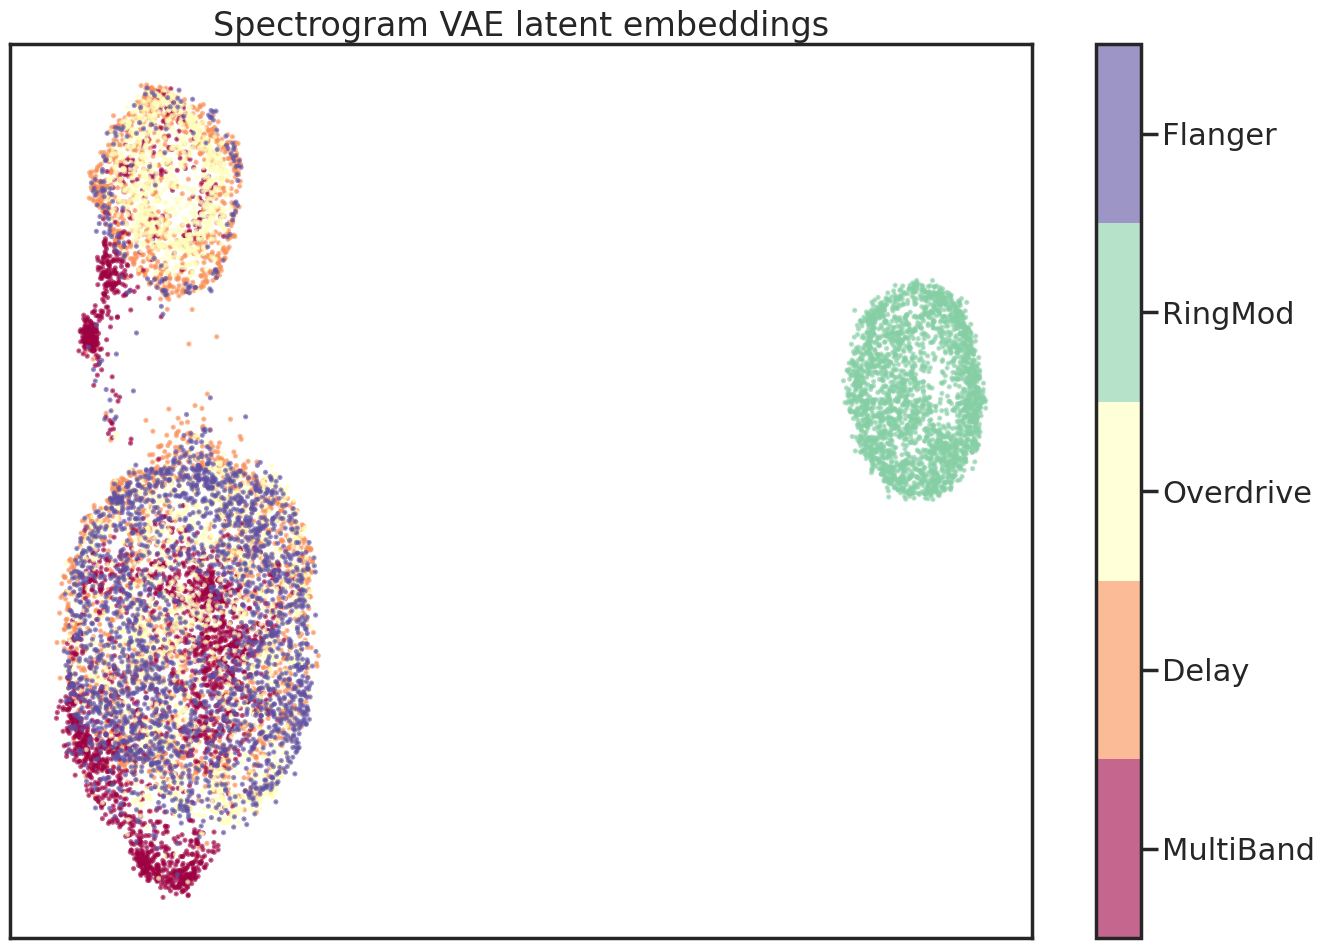

In [73]:
fig, ax = plt.subplots(1, figsize=(14, 10))

plt.scatter(*umap_data.T, s=3, c=plot_labels, cmap='Spectral', alpha=.6)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(num_fx+1)-0.5)
cbar.set_ticks(np.arange(num_fx))
cbar.set_ticklabels([fx_name.split()[-1] for fx_name in DAFX_TO_USE])
plt.title(f'Spectrogram VAE latent embeddings')
plt.tight_layout()
plt.savefig(f'./figures/latent_analysis/{CHECKPOINT_ID}_{num_fx}dafx.png')

In [74]:
quantized.shape

torch.Size([4, 8, 28, 28])